In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [36]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [42]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Flatten(),
        nn.Linear(in_features=128*4*4,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=10)
        # nn.Softmax()
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [43]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [44]:
# Hyperparameters
learning_rate = .02
num_epochs = 2


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [45]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 1: 100%|██████████| 937/937 [03:17<00:00,  4.75it/s]


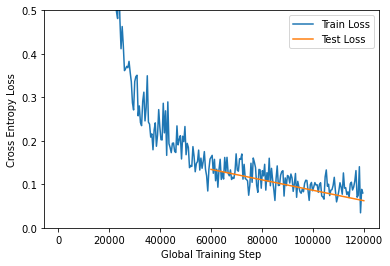

Final Test loss: 0.062348344162696745. Final Test accuracy: 0.9792


In [47]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .5])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")